We've seen example days where the hybrid ML forecast seems to add useful probabilistic information, but how does it compare to a persistence ensemble forecast? Let's use 2021 and 2022 data to capture the distribution of observations and then apply that to 2023 and see how sharp it is compared to our ML forecast, i.e., let's compare prediction interval normalized average width, or PINAW.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in our full dataset of features and actuals:

In [2]:
df = pd.read_pickle('data_files/full_2021_2023_dataset.pkl')

Define the prediction interval and percentile lists (use the same target PIs we used for the ML models):

In [3]:
pi_list_rf = [.995, .99, .98, .95, .5]
pi_list = pi_list_rf

percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)
print(percentile_list)

# multiply by 100 to convert percentile_list to percentages
constant_values = [x * 100 for x in percentile_list]
print(constant_values)

[0.0025, 0.005, 0.01, 0.025, 0.25, 0.5, 0.75, 0.975, 0.99, 0.995, 0.9975]
[0.25, 0.5, 1.0, 2.5, 25.0, 50.0, 75.0, 97.5, 99.0, 99.5, 99.75]


Define a function for a persistence probabilistic forecast:

In [4]:
# based on https://solarforecastarbiter-core.readthedocs.io/en/latest/_modules/solarforecastarbiter/reference_forecasts/persistence.html#persistence_probabilistic
def persistence_probabilistic(observation, constant_values, fx_index):
    forecasts = []
    for constant_value in constant_values:
        fx = np.nanpercentile(observation, constant_value) # need to ignore nan values
        forecasts.append(pd.Series(fx, index=fx_index))
    return forecasts

Run that function using 2021 and 2022 to calculate probabilities, and apply them to 2023. Everything is normalized to clear sky for now.

Because we used a relatively high clear sky model, there are many hours where actual clear sky index is zero, which skews the probabilities. We will exclude any interval where clear sky power (_csi_actual_) is zero. 

In [5]:
# csi_persistence_prob = persistence_probabilistic(df.csi_actual,constant_values)

data_start = '2021-01-01'
data_end = '2023-01-01'
obs_mask = (df.index >= data_start) & (df.index < data_end)
fx_start = '2023-01-01'
fx_end = '2024-01-01'
fx_mask = (df.index >= fx_start) & (df.index < fx_end)

df.loc[(df.csi_actual <= 0)] = np.nan

csi_persistence_prob = persistence_probabilistic(
    df.csi_actual[obs_mask],
    constant_values,
    fx_index = df.index[fx_mask])

result_df_persist = df.copy()[fx_mask]

Let's check to see how many hours where excluded by filtering out _csi_actual_ == 0:

In [6]:
a = (~np.isnan(df.csi_actual) & (df.index >= data_start) & (df.index < data_end)).sum()
b = (~np.isnan(df.csi_actual) & (df.index >= data_start) & (df.index < data_end) & (df.csi_actual == 0)).sum()
print('total daytime hours in obs: ' + str(a))
print('daytime hours in obs with (csi_actual==0): ' + str(b))
print('fraction: ' + str(b/a))

total daytime hours in obs: 8932
daytime hours in obs with (csi_actual==0): 0
fraction: 0.0


Now, "un-normalize" from clear sky to actual power:

In [7]:

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    # set nighttime values to nan
    csi_persistence_prob[i][np.isnan(df['csi_actual'])] = np.nan
    result_df_persist[str(percentile_list[i])+'_persist_csi']=csi_persistence_prob[i]
for i in range(len(percentile_list)):
    result_df_persist[str(percentile_list[i])+'_persist_p_ac']=csi_persistence_prob[i]*df['p_ac_all_cs']

Quick plot of a few percentiles, to make sure things look reasonable:

<Axes: xlabel='time_center_labeled'>

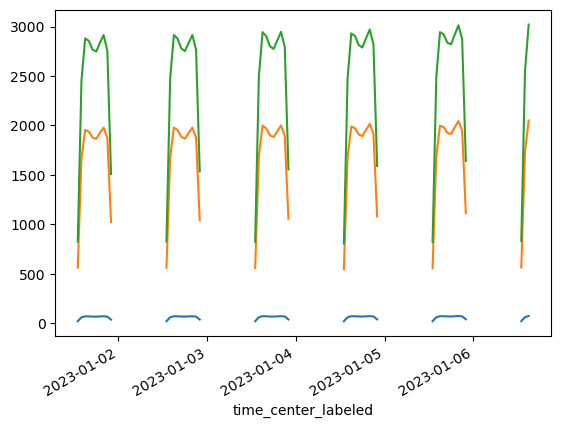

In [8]:
result_df_persist['0.025_persist_p_ac'][0:100].plot()
result_df_persist['0.5_persist_p_ac'][0:100].plot()
result_df_persist['0.975_persist_p_ac'][0:100].plot()

And our coverage fraction function:

In [9]:
# from https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [10]:
# coverage fraction:
cf_persist = {}
for i in range(num_intervals):
    cf_persist[i] = coverage_fraction(df['csi_actual'][fx_mask].dropna(),
                              csi_persistence_prob[i].dropna(),
                              csi_persistence_prob[len(percentile_list)-i-1].dropna()
    )

print('target prediction intervals:')
print(pi_list)
print('resulting coverage fraction (rounded to 4 places):')
print([ '%.4f' % elem for elem in list(cf_persist.values())])

target prediction intervals:
[0.995, 0.99, 0.98, 0.95, 0.5]
resulting coverage fraction (rounded to 4 places):
['0.9966', '0.9908', '0.9789', '0.9429', '0.4945']


And sharpness (PINAW):

In [11]:
approx_nameplate = df.p_ac_all_act.max()

# sharpness
print('target PI : resulting CF : width')
for i in range(num_intervals):
    lower = result_df_persist[str(percentile_list[i])+'_persist_p_ac'] # lower
    upper = result_df_persist[str(percentile_list[len(percentile_list)-i-1])+'_persist_p_ac'] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_persist.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

print('for zenith < 75:')

mask_zen = (result_df_persist['zen'] < 75) 

cf_mask = {}
for i in range(num_intervals):
    cf_mask[i] = coverage_fraction(result_df_persist['p_ac_all_act'][mask_zen],
                              result_df_persist[str(percentile_list[i])+'_persist_p_ac'][mask_zen],
                              result_df_persist[str(percentile_list[len(percentile_list)-i-1])+'_persist_p_ac'][mask_zen]
    )

for i in range(num_intervals):
    lower = result_df_persist[str(percentile_list[i])+'_persist_p_ac'][mask_zen] # lower
    upper = result_df_persist[str(percentile_list[len(percentile_list)-i-1])+'_persist_p_ac'][mask_zen] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_mask.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

target PI : resulting CF : width
0.995 : 0.997 : 0.8080584905497249
0.99 : 0.991 : 0.7992371531273108
0.98 : 0.979 : 0.7908535807452585
0.95 : 0.943 : 0.7749583307398559
0.5 : 0.494 : 0.45008720180158995
for zenith < 75:
0.995 : 0.998 : 0.9294091439641139
0.99 : 0.995 : 0.9192630570678461
0.98 : 0.984 : 0.9096204768312797
0.95 : 0.957 : 0.8913381484189309
0.5 : 0.512 : 0.517679308896362


Now, let's re-calculate those same values for our ML forecast. To keep the comparison "apples-to-apples" we will exclude intervals where clear sky index of actual power is zero, so these results will be slightly different from what we saw in notebook 09. 

In [12]:
result_df = pd.read_pickle('data_files\hybrid_prob_fcast_results_2023.pkl')

ml_fx_mask = (result_df.index >= fx_start) & (result_df.index < fx_end)

result_df = result_df.copy()[ml_fx_mask]

result_df.loc[(result_df.csi_actual <= 0)] = np.nan

# coverage fraction:
cf = {}
for i in range(num_intervals):
    cf[i] = coverage_fraction(result_df['p_ac_all_act'],
                              result_df[str(percentile_list[i])+'_p_ac'],
                              result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac']
    )

print('target prediction intervals:')
print(pi_list)
print('resulting coverage fraction (rounded to 4 places):')
print([ '%.4f' % elem for elem in list(cf.values())])

target prediction intervals:
[0.995, 0.99, 0.98, 0.95, 0.5]
resulting coverage fraction (rounded to 4 places):
['0.5045', '0.4923', '0.4826', '0.4594', '0.2235']


In [13]:
# sharpness
print('target PI : resulting CF : width')
for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

print('for zenith < 75:')

mask_zen = (result_df['zen'] < 75) 

cf_mask = {}
for i in range(num_intervals):
    cf_mask[i] = coverage_fraction(result_df['p_ac_all_act'][mask_zen],
                              result_df[str(percentile_list[i])+'_p_ac'][mask_zen],
                              result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen]
    )

for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'][mask_zen] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_mask.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

target PI : resulting CF : width
0.995 : 0.504 : 0.5923829575246016
0.99 : 0.492 : 0.5392830204336786
0.98 : 0.483 : 0.46303682035281435
0.95 : 0.459 : 0.3739886863100553
0.5 : 0.224 : 0.11865020465689781
for zenith < 75:
0.995 : 0.992 : 0.6791741037183593
0.99 : 0.971 : 0.6192741030415608
0.98 : 0.949 : 0.534887840748285
0.95 : 0.902 : 0.4339464064001418
0.5 : 0.436 : 0.13728946719774485


Our coverage fractions (prediction interval coverage probability, or PICP) went down slightly after filtering out hours with zero power. 

But, we can manually compare PIs from the persistence forecast and ML forecast that have similar coverage fractions. 

For example, the ML target PI of 0.98 has an actual PICP of 0.95 and a width of 0.46. Compare that with the persistence target PI of 0.95 that has an actual width of 0.94 and a width of 0.77. The ML forecast has a roughly 40% narrower PINAW for a slightly better PICP. 

Looking at the target PI 0.995 in the ML forecast, it has PICP of 0.993 and PINAW of 0.59. That PICP falls between two PIs for the persistence forecast, which have PINAW values of 0.80 and 0.81, so the ML forecast has a 25% narrower PINAW. 

And the lowest PI: the target PI 0.5 in the ML forecast has a slightly lower PICP (0.44 vs 0.49 in the persistence forecast), but the PINAW is 0.12 vs 0.45 in the persistence forecast, an over 70% narrower PINAW.

Here's a plot of the ML forecast over a sample time range that we looked at previously in [09_machine_learning_models.ipynb](09_machine_learning_models.ipynb):

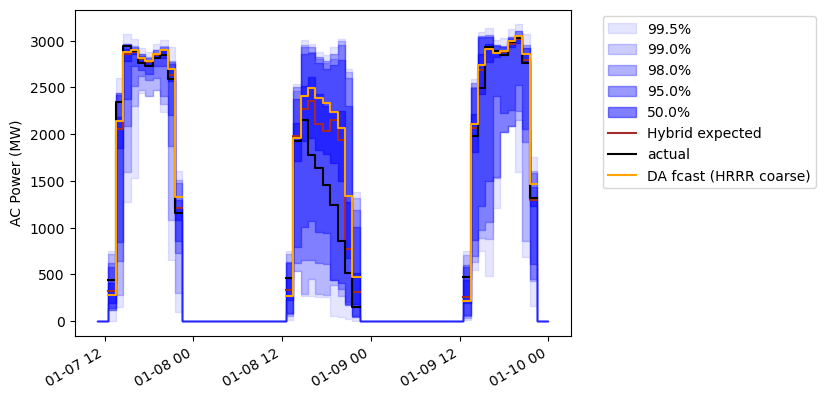

In [14]:
mask_start = '2023-1-7 11:00'
mask_end = '2023-1-10'

mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

And here's the same time range for the PeEn forecast:

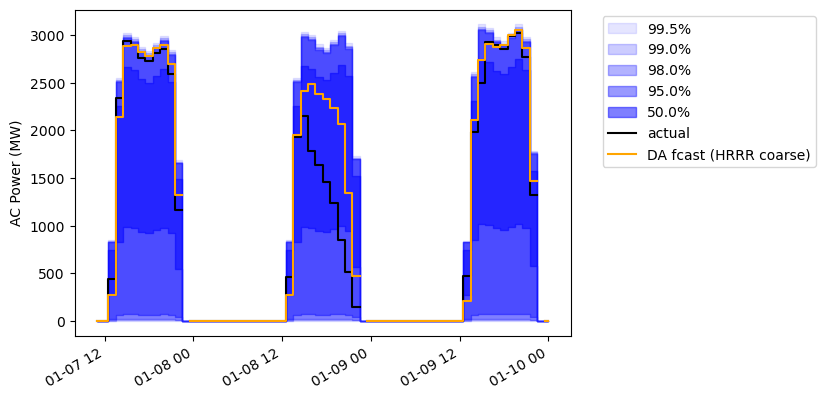

In [15]:
mask_start = '2023-1-7 11:00'
mask_end = '2023-1-10'

mask = (result_df_persist.index >= mask_start) & (result_df_persist.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df_persist.index[mask],# x
                     result_df_persist[str(percentile_list[i])+'_persist_p_ac'][mask].fillna(0), # lower
                     result_df_persist[str(percentile_list[len(percentile_list)-i-1])+'_persist_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df_persist.index[mask],result_df_persist['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df_persist.index[mask],result_df_persist['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

And that concludes the demonstration of this tool. Thanks for your interest!